# Vehicle Detection and Tracking

#### Paul Comitz 9/25/2017

##### The goal of this project is to detect and track any vehicle which is in range of the vehicle. The pipeline to achieve this is as follows:
1.  A Histogram of Oriented Gradients (HOG) feature extraction is performed on a labeled training set of images that are used to train a Linear SVM classifier. 
2. A color transform, binned color features, as well as histograms of color, are used with the HOG feature vector.
3. Features are normalized abd randomized for training and testing.
4. A linear SVC classifier is trained using the feature vectors described above. 
5. A sliding-window technique is implemented, and the  trained SVC classifier is used to search for vehicles in images.
6. The image procesing pipeline is run on a video stream (project_video.mp4). A  heat map of recurring detections frame by frame is used to reject outliers,  follow detected vehicles, and elimate duplicates. 
7. An estimated bounding box for vehicles detected is computed. 

This  is the Writeup/README for Project 5. Details for each step are described below. 

### Histogram of Gradient Features 

#### 1.  Extract Histogram of Oriented Gradients (HOG) Features 
To begin, use the provided data to train a Linear SVM classifier. For vehicle I used <b>8000</b> car images and <b>8000</b> not cars image. The details for the data set are shwon below.
- Number of car Images:  8792
- Number of not car Images :  8968
- Image Shape :  (64, 64, 3)
- Image Data type :  float32

The code to read the images is in the python file <code>project5.py</code> starting at (or about) line 200. Examples images from the data sets are shown below.

Car Image
![Car image](files/../vehicles/vehicles/GTI_Far/image0000.png)

Not Car Image
![notCar image](files/../non-vehicles/non-vehicles/Extras/extra1.png)

With the <b>HOG</b> technique gradient magnitude and direction is computed on a pixel by pixel basis.  In a 64 x 64 image : 
- Divide the image into 8 x 8 cells
- Compute the histogram of gradient directions (orientions) fro each of the 64 pixels in the cell


The <b>HOG</b> technique is useful as a signature for a shape (such as a car). 

HOG Features are part of the overall feature extrtaction approach which is a central element of Project 5. In this project the HOG features are computed using the <code>hog</code> funcion from <code>skimage.feature</code>. This fnctionality is contained in the function <code>get_hog_features</code> in the python source file <code>lesson_functions_34.py</code> . This function is called by the <code>extract_features</code> function, which is called by the functions  used to process each frame of video called <code>process_image</code>. 

An example of the <b>HOG</b> techniques is shown below. 

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


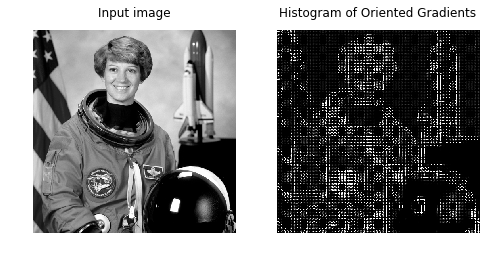

In [1]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, color, exposure
import numpy as np

image = color.rgb2gray(data.astronaut())
pix_per_cell = 8
cell_per_block = 2
orient = 9

#configure HOG
pix_per_cell = 8
cell_per_block = 2
orient = 9
features, hog_image = hog(image, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box-forced')
plt.show()

This example above uses an test image from <code>skimage</code>. This example visually shows how HOG can be used as a signature for a shape. 

In addition ot the HOG features I used spatial features, and histogram features  construct the feature vectors. Typcial results of the Color Classification were: 

<code>
Using spatial binning of: 16 and 384 histogram bins
Feature vector length: 1920
0.29 Seconds to train SVC...
Test Accuracy of SVC =  0.9896
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  1.  1.  1.  1.]
0.0011 Seconds to predict 10 labels with SVC. 
</code>

The feature vectors  are built in the <code>extract_features</code> function in the python source file <code>lesson_functions34.py</code>. 

#### 2. Choice of Parameters 

For the HOG parameters I used pix_per_cell as 8, cells per block of 2, and 9 orientations. I used hog_channel channel of 'ALL" as this seemed to have the best results. 

For the color channel the  YCrCb colorspace  gave better results, especially on tech white cars.

For the histogram bins I used 384. During testing I observed the best experimental results with a spatial size of (16,16) and 384 for the histogram bins. With this combination I observed a test accuracy of > 98% with the linear SVC classifier that was used. 

In all cases the choice of parameters was heavily influenced by experimentation  and conversation with other students  and mentors in the forums. 

NOTE: With some combinations of paramtersI noted a frame processing time of as much as 60 seconds per frame. I did not use any of these combinations. 

The code snippet below appears in the python source file <code>project5.py</code>

In [3]:
# parameters
color_space = 'YCrCb'
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 384    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [350, 700] # Min and max in y to search in slide_window()
x_start_stop = [None,None] # changed to  200, 1280 then changed backto [None, None]
 

#### 3. Training Classifier/Code Examples

This is the code that is used to train the classifier using he supplied labeled data set, The vehicle is classified using the Linear SVC classification algorithm. The histogram, spatial and HOG features of the vehicle and non vehicle images are extracted, then the features are scaled so that no one feature dominates the others.

The data set is split into a training and test data set. 

This <code>extract_features</code> method shown below, is called from the <code>process_image</code> method. The <code>process_image</code> method is called for each frame of video that is processed (see <code>lesson5.py</code>)

In [ ]:
# Extract features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=42)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

The parameters above are used with functions adapted from example code supplied in the lessons. This code is shown below and is also shown in the  python source file <code>lesson_functions43.py</code>. The code examples shown below are called from the <code>extract_features</code> method. 


In [4]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    


### Sliding Window Search 

The sliding window search that was used is basicially the technique that is shown in the class. The following choices were made based on experimentaion:
- x,y window = 96, 96
- overlap = 50%, 50%
- y_start_stop = 350, 700

Other choces were tried such as 32, 32 for the window size, and 75%, 75% for the overlap. In some cases the processing was so slow that these choices were abandoned.  

As described in class, multi-scale windows were used to accomodate vehicles at different distances.  The sliding window code appears in the python soucrce file <code>lesson_functions34.py</code> 

### Example Visualizations 

#### Filter Multiple and False Detections 
The outliers and duplicates were filtered using the heatmap technique shown in class. This code is contained in the python soucre file <code>multipleDetectionsAndFalsePositives_37.py</code>

An example is shown in the image below. This image shows the detections and the heatmap from one of the test images.  

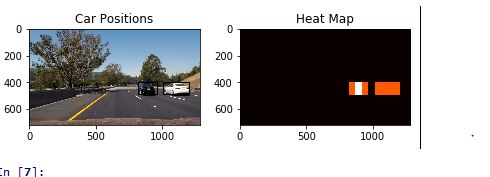

#### Detection
Another example is shown below. This is a better view of the image above. It shows that the classifier has detetcued the black car and teh white car. A bounding box has been drawn around each detection. 
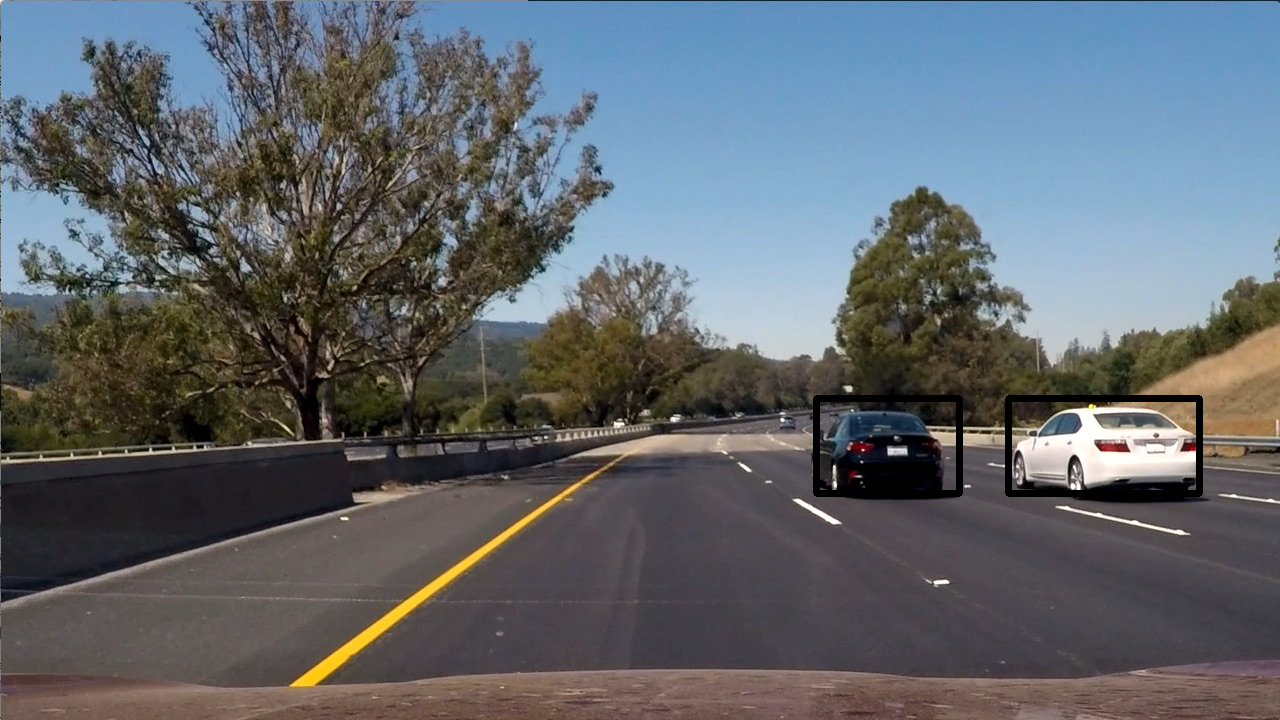

### Video Implementation

The video is present in the github repository for this project. The name of the vidoe is <i>proj5.mp4.</i> 


### Discussion

The project was quite challengeing. There is much more that could be done. My semester ended on September 4, so I am very time-constrained at this point. 

Observations and Areas for Improvement

1. The detection window is wobbly on the video and could be much smoother. As discussed in one of the forum posts (but only mentioned very briefly in passing in class) there is a technique to save the results from several frames and apply a centroid when there are overlapping detections. I would have liked to have tried this technique, but I ran out of time. 

2. With some parameter choices the pipeline can be quite slow. As indicated in this writeup, there are places where the the processing was taking as much as 60 seconds per frame. I would have liked to have investigated this more thoroughly. The final pipeline was reasonably fast (approx 1 second per frame) but no where near the real-time that is ultimately required. 

3. It would be quite interesting to observe the performance of other classifiers such as a non-linear SVC, or neural network. Due to the conditional indepedence assumptions, I wonder if naive Bayes is even viable. 

Thanks for an interesting semester. 